<a href="https://colab.research.google.com/github/srihari-humbarwadi/image_colorization_gan_tf2.0/blob/master/model/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install tensorflow-gpu==2.0.0
import logging
logger = logging.getLogger("tensorflow")
logger.setLevel(logging.INFO)

from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.color import rgb2lab, lab2rgb, rgb2gray
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from tqdm import tqdm_notebook

tf.enable_v2_behavior()
print('TensorFlow', tf.__version__)
print('TensorFlow Datasets', tfds.__version__)
print('Executing eagerly =>', tf.executing_eagerly())
!nvidia-smi

TensorFlow 1.15.0
TensorFlow Datasets 1.3.0
Executing eagerly => True
Wed Oct 30 10:15:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:      

In [0]:
!apt install aria2 -y
!aria2c -j 16 "http://files.fast.ai/data/imagenet-sample-train.tar.gz"
!tar -xvf imagenet-sample-train.tar.gz

In [0]:
def imshow(image, title=None):
    plt.figure(figsize=(16, 9))
    plt.axis('off')
    if title:
        plt.title(title)
    cmap = None if image.ndim == 3 else 'gray'
    plt.imshow(image, cmap=cmap)
    
def downscale_conv2D(tensor, n_filters, kernel_size=4, strides=2, name=None, use_bn=True):
    _x = tf.keras.layers.Conv2D(filters=n_filters,
                                kernel_size=kernel_size,
                                strides=strides, 
                                padding='same',
                                use_bias=False,
                                name='downscale_block_' + name + '_conv2d', 
                                activation=None)(tensor)
    if use_bn:
        _x = tf.keras.layers.BatchNormalization(name='downscale_block_' + name + '_bn')(_x)
    _x = tf.keras.layers.LeakyReLU(alpha=0.2, name='downscale_block_' + name + '_lrelu')(_x)
    return _x

def upscale_deconv2d(tensor, n_filters, kernel_size=4, strides=2, name=None):
    _x = tf.keras.layers.Conv2DTranspose(filters=n_filters,
                                         kernel_size=kernel_size,
                                         strides=strides, 
                                         padding='same',
                                         use_bias=False,
                                         name='upscale_block_' + name + '_conv2d', 
                                         activation=None)(tensor)
    _x = tf.keras.layers.BatchNormalization(name='upscale_block_' + name + '_bn')(_x)
    _x = tf.keras.layers.ReLU(name='upscale_block_' + name + '_relu')(_x)
    return _x

def build_generator():
    _input = tf.keras.Input(shape=[256, 256, 1], name='image_input')
    x = downscale_conv2D(_input, 64, strides=1, name='0')
    features = [x]
    for i, n_filters in enumerate([64, 128, 256, 512, 512, 512, 512]):
        x = downscale_conv2D(x, n_filters, name=str(i+1))
        features.append(x)

    for i, n_filters in enumerate([512, 512, 512, 256, 128, 64, 64]):
        x = upscale_deconv2d(x, n_filters, name=str(i+1))
        x = tf.keras.layers.Concatenate()([features[-(i+2)], x])
    _output = tf.keras.layers.Conv2D(filters=3, 
                                     kernel_size=1, 
                                     strides=1, 
                                     padding='same',
                                     name='output_conv2d', 
                                     activation='tanh')(x)
    return tf.keras.Model(inputs=[_input], outputs=[_output], name='Generator')

def build_discriminator():
    _input = tf.keras.Input(shape=[256, 256,  4])
    x = downscale_conv2D(_input, 64, strides=2, name='0', use_bn=False)
    x = downscale_conv2D(x, 128, strides=2, name='1')
    x = downscale_conv2D(x, 256, strides=2, name='2')
    x = downscale_conv2D(x, 512, strides=1, name='3')
    _output = tf.keras.layers.Conv2D(filters=1,
                                     kernel_size=1, 
                                     strides=1, 
                                     padding='same', 
                                     name='output_conv2d', 
                                     activation=None)(x)
    return tf.keras.Model(inputs=[_input], outputs=[_output], name='Discriminator')

In [0]:
class Colorizer:
    def __init__(self, config):
        super(Colorizer, self).__init__()
        self.distribute_strategy = config['distribute_strategy']
        self.epochs = config['epochs']
        self.batch_size = config['batch_size']
        self.d_lr = config['d_lr']
        self.g_lr = config['g_lr']
        self.image_list = config['image_list']
        self.model_dir = config['model_dir']
        self.tensorboard_log_dir = config['tensorboard_log_dir']
        self.checkpoint_prefix = config['checkpoint_prefix']
        self.restore_parameters = config['restore_parameters']
        self.build_dataset()
        self.initialize_loss_objects()
        self.initialize_metrics()
        self.build_models()
        self.create_optimizers()
        self.create_checkpoint_manager()
        self.create_summary_writer()
        
    def build_models(self):
        print('++++Building Models')
        with self.distribute_strategy.scope():
            self.generator = build_generator()
            self.discriminator = build_discriminator()

    def build_dataset(self):
        print('++++Building Dataset')
        self.steps = len(self.image_list) // self.batch_size
        def preprocess_input(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, size=[256, 256])
            
            def _preprocess_input(image):
                image_n = np.uint8(image.numpy())
                image_gray = np.float32(rgb2gray(image_n.copy()))
                image_lab = np.float32(rgb2lab(image_n.copy()))
                image_gray =  image_gray*2 - 1
                image_lab = tf.stack([
                    image_lab[..., 0]/50 - 1,
                    image_lab[..., 1]/110,
                    image_lab[..., 2]/110,
                ], axis=-1)
                return image_gray[..., None], image_lab
            return tf.py_function(_preprocess_input, [image], [tf.float32, tf.float32])
        
        with self.distribute_strategy.scope():
            self.dataset = tf.data.Dataset.from_tensor_slices(self.image_list)
            self.dataset = self.dataset.map(preprocess_input,
                                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
            self.dataset = self.dataset.batch(self.batch_size, drop_remainder=True)
            self.dataset = self.dataset.prefetch(tf.data.experimental.AUTOTUNE)
            self.dataset = self.distribute_strategy.experimental_distribute_dataset(self.dataset)
        
    def create_optimizers(self):
        print('++++Creating Optimizers')
        with self.distribute_strategy.scope():
            self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=self.d_lr)
            self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=self.g_lr)  
    
    def initialize_loss_objects(self):
        with self.distribute_strategy.scope():
            self.bce_smooth = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                                 label_smoothing=0.1,
                                                                 reduction=tf.keras.losses.Reduction.NONE)
            self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                          reduction=tf.keras.losses.Reduction.NONE)     
    
    def initialize_metrics(self):
        with self.distribute_strategy.scope():
            self.generator_loss = tf.keras.metrics.Mean(name='generator_loss')
            self.discriminator_loss_real = tf.keras.metrics.Mean(name='discriminator_loss_real')   
            self.discriminator_loss_fake = tf.keras.metrics.Mean(name='discriminator_loss_fake')
            self.psnr = tf.keras.metrics.Mean(name='PSNR')
            
    def create_checkpoint_manager(self):
        with self.distribute_strategy.scope():
            self.checkpoint = tf.train.Checkpoint(generator=self.generator, 
                                                  discriminator=self.discriminator, 
                                                  g_optimizer=self.g_optimizer,
                                                  d_optimizer=self.d_optimizer)
            if self.restore_parameters:
                print('++++Restoring Parameters')
                latest_checkpoint = tf.train.latest_checkpoint(self.model_dir)
                self.status = self.checkpoint.restore(latest_checkpoint)
                        
    def create_summary_writer(self):
        self.summary_writer = tf.summary.create_file_writer(logdir=self.tensorboard_log_dir)
            

    def loss_G(self, fake_logits, real, fake):
        bce_loss = tf.reduce_mean(self.bce(tf.ones_like(fake_logits),
                                           fake_logits), axis=[1, 2])
        l1_loss = tf.reduce_mean(tf.abs(real - fake), axis=[1, 2, 3])
        return tf.nn.compute_average_loss(bce_loss + l1_loss,
                                          global_batch_size=self.batch_size)

    def loss_D_real(self, real_logits):
        real_loss = tf.reduce_mean(self.bce_smooth(tf.ones_like(real_logits),
                                                   real_logits), axis=[1, 2])
        return tf.nn.compute_average_loss(real_loss,
                                          global_batch_size=self.batch_size)

    def loss_D_fake(self, fake_logits):
        fake_loss = tf.reduce_mean(self.bce(tf.zeros_like(fake_logits),
                                               fake_logits), axis=[1, 2])
        return tf.nn.compute_average_loss(fake_loss,
                                          global_batch_size=self.batch_size)
    
    def compute_psnr(self, real, fake):
        psnr = tf.image.psnr(real, fake, max_val=1.0)
        return tf.reduce_sum(psnr, axis=0) / self.batch_size
    
    def write_summaries(self, metrics):
        d_real_loss, d_fake_loss, g_loss, psnr = tf.split(metrics, num_or_size_splits=4)
        with self.summary_writer.as_default():
            tf.summary.scalar('discriminator_loss_real',
                              d_real_loss[0], step=self.iterations)
            tf.summary.scalar('discriminator_loss_fake',
                              d_fake_loss[0], step=self.iterations)
            tf.summary.scalar('generator_loss',
                              g_loss[0], step=self.iterations)
            tf.summary.scalar('PSNR', psnr[0], step=self.iterations)
            
    def write_checkpoint(self):
        with self.distribute_strategy.scope():
            self.checkpoint.save(os.path.join(self.model_dir,
                                              self.checkpoint_prefix))            
    
    def update_metrics(self, metrics):
        d_real_loss, d_fake_loss, g_loss, psnr = tf.split(metrics, num_or_size_splits=4)
        self.generator_loss.update_state(g_loss)
        self.discriminator_loss_real.update_state(d_real_loss)
        self.discriminator_loss_fake.update_state(d_fake_loss)
        self.psnr.update_state(psnr)
    
    def reset_metrics(self):
        self.generator_loss.reset_states()
        self.discriminator_loss_real.reset_states()
        self.discriminator_loss_fake.reset_states()
        self.psnr.reset_states()
        
    def log_metrics(self):
        metrics_dict = {
            'epoch':self.epoch,
            'batch':self.iterations,
            'generator_loss':np.round(self.generator_loss.result(), 3)
            'discriminator_loss_real':np.round(self.discriminator_loss_real.result(), 3)
            'discriminator_loss_fake':np.round(self.discriminator_loss_fake.result(), 3)
            'psnr':np.round(self.psnr.result(), 3)
        }
        logger.info(metrics_dict)
        
    def train(self):
        print('++++Starting Training Loop')
        if self.restore_parameters:
            self.restore_status.assert_consumed()
            
        @tf.function
        def train_step(grayscale_image, lab_image):
            real_input = tf.concat([grayscale_image, lab_image], axis=-1)
            with tf.GradientTape() as r_tape:
                real_logits = self.discriminator(real_input, training=True)
                d_real_loss = self.loss_D_real(real_logits)
            d_r_gradients = r_tape.gradient(d_real_loss,
                                            self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_r_gradients,
                                                 self.discriminator.trainable_variables))

            with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
                fake_image = self.generator(grayscale_image, training=True)
                fake_input = tf.concat([grayscale_image, fake_image], axis=-1)
                fake_logits = self.discriminator(real_input, training=True)

                d_fake_loss = self.loss_D_fake(fake_logits)
                g_loss = self.loss_G(fake_logits, lab_image, fake_image)
            d_f_gradients = d_tape.gradient(d_fake_loss,
                                            self.discriminator.trainable_variables)
            g_gradients = g_tape.gradient(g_loss,
                                          self.generator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_f_gradients,
                                                 self.discriminator.trainable_variables))
            self.g_optimizer.apply_gradients(zip(g_gradients,
                                                 self.generator.trainable_variables))
            psnr = self.compute_psnr(lab_image, fake_image)
            metrics = tf.stack([d_real_loss, 
                               d_fake_loss, 
                               g_loss, 
                               psnr], axis=-1)
            return tf.reshape(metrics, shape=[1, -1])
    
        @tf.function
        def distributed_train_step(grayscale_image, lab_image):
            per_replica_metrics = self.distribute_strategy.experimental_run_v2(fn=train_step,
                                                                 args=(grayscale_image, lab_image))
            reduced_metrics = self.distribute_strategy.reduce(tf.distribute.ReduceOp.SUM,
                                              per_replica_metrics, axis=0)
            return reduced_metrics
        
        self.epoch = 0
        for _ in range(self.epochs):
            self.iterations = 0
            for grayscale_image, lab_image in tqdm_notebook(self.dataset, total=self.steps):
                metrics = distributed_train_step(grayscale_image, lab_image)
                self.update_metrics(metrics)
                self.log_metrics()
                self.iterations += 1
            self.write_summaries(metrics)
            self.reset_metrics()
            self.write_checkpoint()
            self.epoch += 1

In [7]:
config = {
    'distribute_strategy':tf.distribute.OneDeviceStrategy(device='/gpu:0'),
    'epochs':200,
    'batch_size':16,
    'd_lr':1e-4,
    'g_lr':1e-4,
    'image_list':glob('train/*/*'),
    'model_dir':'model_dir',
    'tensorboard_log_dir':'logs',
    'checkpoint_prefix':'ckpt',
    'restore_parameters':False
}
colorizer = Colorizer(config)
colorizer.train()

++++Building Dataset
++++Building Models
++++Creating Optimizers
++++Starting Training Loop


tf.Tensor([0.7475748 1.3629348 1.8084495 3.2533627], shape=(4,), dtype=float32)
tf.Tensor([0.7941824 0.9391007 1.3154604 4.45691  ], shape=(4,), dtype=float32)
tf.Tensor([0.731057  0.8568057 1.2119944 4.819574 ], shape=(4,), dtype=float32)
tf.Tensor([0.7545878  0.84895587 1.1806221  5.0535555 ], shape=(4,), dtype=float32)
tf.Tensor([0.6960033 0.8025704 1.076322  6.1832733], shape=(4,), dtype=float32)
tf.Tensor([0.7091911 0.8088732 1.0651935 6.5321617], shape=(4,), dtype=float32)
tf.Tensor([0.6934313  0.78917307 1.0517143  6.75385   ], shape=(4,), dtype=float32)
tf.Tensor([0.69523287 0.78635323 1.0543237  7.0889497 ], shape=(4,), dtype=float32)
tf.Tensor([0.6941385 0.769389  1.0297363 7.009062 ], shape=(4,), dtype=float32)
tf.Tensor([0.6872011 0.7560184 1.0323035 7.0722084], shape=(4,), dtype=float32)
tf.Tensor([0.68401027 0.75270116 1.0079452  7.2321444 ], shape=(4,), dtype=float32)
tf.Tensor([0.6958435  0.74145585 0.98626983 8.297663  ], shape=(4,), dtype=float32)
tf.Tensor([0.6863005

ValueError: ignored

In [0]:
colorizer.write_checkpoint()

In [0]:
from skimage.io import imread
import cv2
import numpy as np

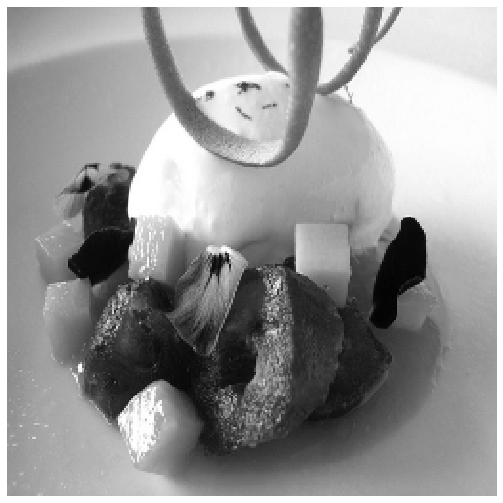

In [23]:
image = imread(colorizer.image_list[0])
image = cv2.resize(image, (256, 256))
image_g = rgb2gray(image)*2 -1
imshow(image_g)

In [0]:
p = colorizer.generator(image_g[None, ..., None], training=False)[0]

In [0]:
pp = np.stack([
    (p[..., 0]+1)*50,
    p[..., 1]*110,
    p[..., 2]*110
], axis=-1)

In [30]:
pp.shape

(256, 256, 3)

In [0]:
ppp = lab2rgb(pp)

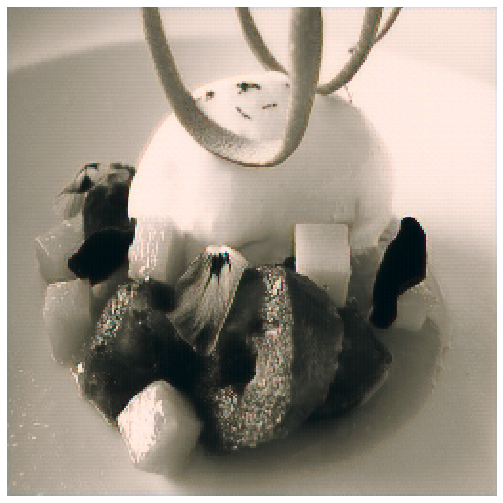

In [33]:
imshow(ppp)

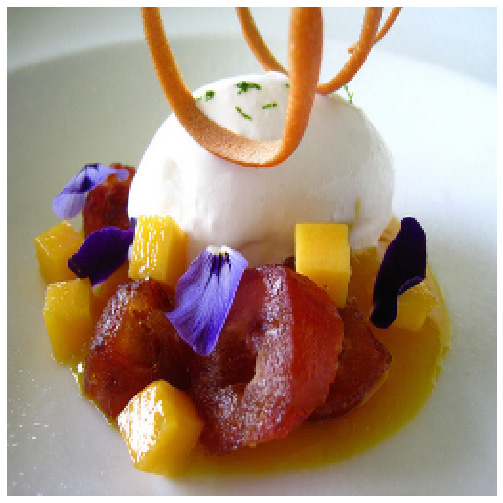

In [34]:
imshow(image)